In [1]:
import sys
import os
import os.path as op

import glob
import numpy as np
import pandas as pd
import datetime
import netCDF4 as netcdf
from datetime import timedelta
from math import pi
import xarray as xr

# dev library
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..'))

# dependencies
from lib import wrapSpectra, spectra, sat, plot_sat, model
from lib.config import * 


# Comparison between WW3 model and CFOSAT partitions

In [2]:
ds_data = xr.open_dataset(op.join(p_output, 'ds_dataTracks.nc'))
ds_params_freqs = xr.open_dataset(op.join(p_output, 'params_freqs_output.nc'))

In [3]:
#ds_part_CFOSAT = wrapSpectra.CFOSAT_partitions(ds_data, beam, min_wavelength, max_wavelength)

In [4]:
ds = xr.open_mfdataset(glob.glob(op.join(p_output, 'process_CFOSATparts', '*')),
                       engine='netcdf4', combine='nested', concat_dim='file', parallel=True)


In [5]:
ds_sat = xr.merge([ds_data, ds]).to_dataframe().dropna().reset_index().set_index('time')

In [6]:
ds_ww3 = xr.open_dataset(op.join(p_output, 'ww3_dataset_hs.nc'))

**Select a time instant**

In [7]:
time = '2021-06-01T18:00:00.000000000'
time1 = '2021-06-01T21:00:00.000000000'
dsi_ww3 = ds_ww3.sel(time=time) 
dfi_sat = ds_sat.loc[(ds_sat.index >= time) & (ds_sat.index < time1)]


In [8]:
dfi_sat = dfi_sat.reset_index()

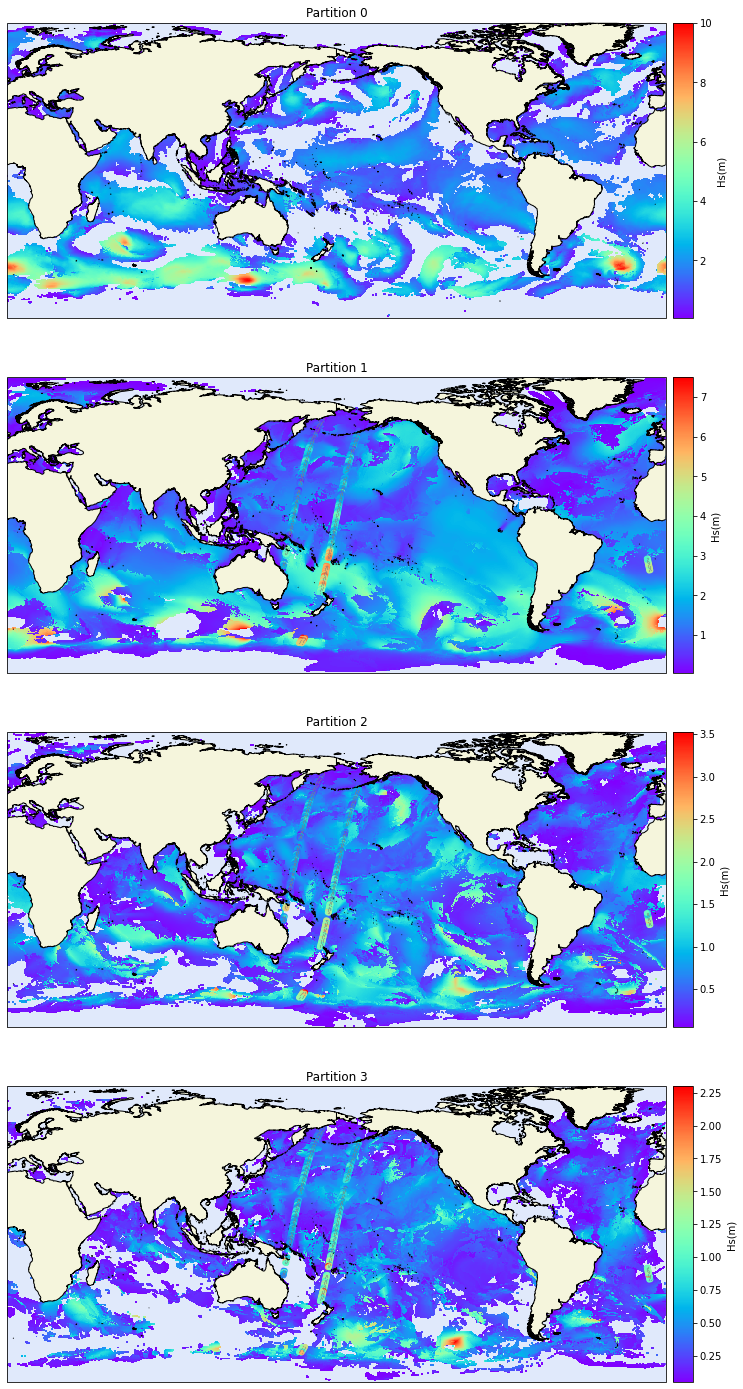

In [29]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig = plt.figure(figsize=(25,25))
gs = fig.add_gridspec(4, 1)

ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180))
ax = plot_sat.map_settings(ax)
im = dsi_ww3['phs0'].plot(
        ax = ax,
        add_colorbar=False,
        cmap='rainbow',
        transform=ccrs.PlateCarree()
    )
ax.set_title('Partition 0')
axc, loc = plot_sat.add_colorbar(ax)
fig.add_axes(axc)
plt.colorbar(im, cax=axc, label='Hs(m)')
    
for part in [0,1,2]:
    data = dfi_sat.loc[np.where(dfi_sat.partition == part+1)]
    
    vmax = np.nanmax([np.nanmax(dsi_ww3['phs{0}'.format(part+1)]), np.nanmax(data['SWH(m)'])])
    # model
    ax = fig.add_subplot(gs[part+1, 0], projection=ccrs.PlateCarree(central_longitude=180))
    ax = plot_sat.map_settings(ax)
    im = dsi_ww3['phs{0}'.format(part+1)].plot(
        ax = ax,
        add_colorbar=False,
        cmap='rainbow',
        transform=ccrs.PlateCarree()
    )

    ax.scatter(data.longitude, data.latitude, c=data['SWH(m)'],cmap='rainbow', s=20, transform=ccrs.PlateCarree())
    ax.scatter(data.longitude, data.latitude, c='gray', s=0.05, transform=ccrs.PlateCarree())
    
    ax.set_title('Partition {0}'.format(part+1))
    axc, loc = plot_sat.add_colorbar(ax)
    fig.add_axes(axc)
    plt.colorbar(im, cax=axc, label='Hs(m)')
